In [739]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import toolz as tz

from astropy.io import fits
from astropy.nddata import NDData
from astropy.stats import SigmaClip
from astropy.table import QTable
from astropy.visualization import simple_norm

from photutils.psf import extract_stars, EPSFBuilder, PSFPhotometry, SourceGrouper, fit_2dgaussian, GaussianPRF, MoffatPSF, CircularGaussianPRF
from photutils.detection import find_peaks
from photutils.centroids import centroid_quadratic, centroid_sources
from photutils.background import Background2D
from photutils.utils import calc_total_error

from sklearn.cluster import DBSCAN

from collections.abc import Mapping

divcmap = sns.color_palette("icefire", as_cmap=True)

plt.rcParams["image.cmap"] = "magma"
plt.rcParams["figure.dpi"] = 120
np.set_printoptions(linewidth=120,legacy="1.21")

# Container class

In [740]:
from dataclasses import dataclass

@dataclass
class BayerImage(Mapping):
    """Represents an image with Bayer pattern:
        ┌────┬────┐
        │ R  │ G1 │
        ├────┼────┤
        │ G2 │ B  │
        └────┴────┘
    Which can be manipulated on a per-channel level with the `apply` method of the class,
    and accessed by member (`BayerImage.G1`) or as a dict (`BayerImage["G1"]`).
    It can also be iterated via dict's `.items` interface.

    This class is not intended to be constructed manually. Use the `from_array` method."""
    R: np.ndarray
    G1: np.ndarray
    B: np.ndarray
    G2: np.ndarray
    channels = ["R","G1","G2","B"]
    def __post_init__(self):
        # check types
        for a,b in self.items():
            if not isinstance(b,np.ndarray):
                raise ValueError(f"Channel {a} of BayerImage must be a ndarray, got {type(b)} instead.")
        # check equal dtypes
        dtypes_set = set(b.dtype for b in self.values())
        if len(dtypes_set) != 1:
            raise ValueError(f"All channels must have the same dtype. Got a mixture with: {dtypes_set}")
        # chech equal shapes
        shapes_set = set(b.dtype for b in self.values())
        if len(shapes_set) != 1:
            raise ValueError(f"All channels must have the same shape. Got a mixture with: {shapes_set}")
    def __len__(self):
        return 4
    def __iter__(self):
        yield from self.channels
    def __getitem__(self,index):
        return getattr(self,index)
    def __setitem__(self,key,value):
        setattr(self,key,value)
    @property
    def dtype(self):
        return self.R.dtype
    def __repr__(self):
        return f"<BayerImage of size {self.R.shape} with {self.dtype} pixels>"
    def copy(self):
        return BayerImage(R=self.R.copy(),G1=self.G1.copy(),B=self.B.copy(),G2=self.G2.copy())
    def apply(self,foo,inplace=False):
        """Apply a function with signature (n,m)->(n,m) to each pixel channel. 
        Applies to a copy if `inplace=False` or to the original arrays otherwise."""
        result = self if inplace else self.copy()
        for c in BayerImage.channels:
            result[c] = foo(result[c])
        return result
    def to_array(self):
        """Reverts the channel separation process back to an array 
        equivalent to that used to construct the BayerImage instance."""
        shape = 2*np.array(self.R.shape)
        result = np.zeros(shape,dtype=self.dtype)
        result[0::2,0::2] = self.R.copy()
        result[1::2,0::2] = self.G1.copy()
        result[0::2,1::2] = self.G2.copy()
        result[1::2,1::2] = self.B.copy()
        return result
    def to_cube(self):
        """Returns a "cube" array, with the first axis being the color channel. 
        Notice this is not a true cube, because the spatial information is off by a quarter of a pixel on all images."""
        return np.array([self.R,self.G1,self.G2,self.B])
    @classmethod
    def from_array(cls,A):
        """Deconstructs the Bayer pattern of the provided array into a BayerImage instance."""
        R  = A[0::2,0::2]
        G1 = A[1::2,0::2]
        G2 = A[0::2,1::2]
        B  = A[1::2,1::2]
        return BayerImage(R=R,G1=G1,B=B,G2=G2)

# Image loading and generalities

The image is loaded with uint16 bitetype. We convert to float to avoid saturation.

In [741]:
2**16-1

65535

In [742]:
image_path = "Light_ngc6231_5.0s_LP_20250911-193300.fit"

img = BayerImage.from_array(fits.getdata(image_path));
img.apply(lambda x: x.astype(np.float32),inplace=True)

<BayerImage of size (960, 540) with float32 pixels>

There are certain bands on this camera where the pixel values are concentrated on specific pixels. This can be seen as the white bands on 480, 620 and 780 counts.

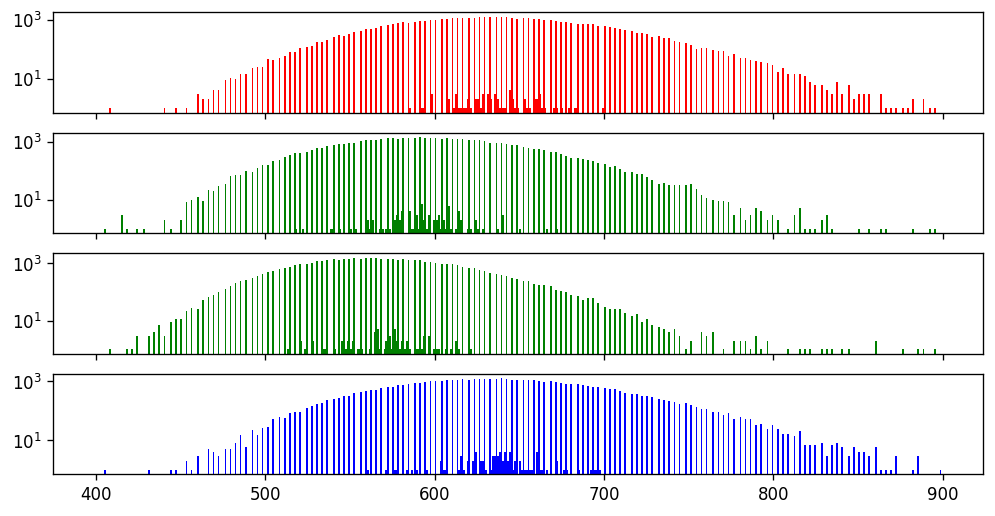

In [743]:
fig,ax = plt.subplots(4,figsize=(10,5),sharex=True)
for i,color in enumerate(BayerImage.channels):
    plt.sca(ax[i])
    plt.hist(img[color].ravel()[::10],bins=np.arange(400,900,1),log=True,color=color[0].lower());
    #plt.axvline(img[color].mean(),c='k')

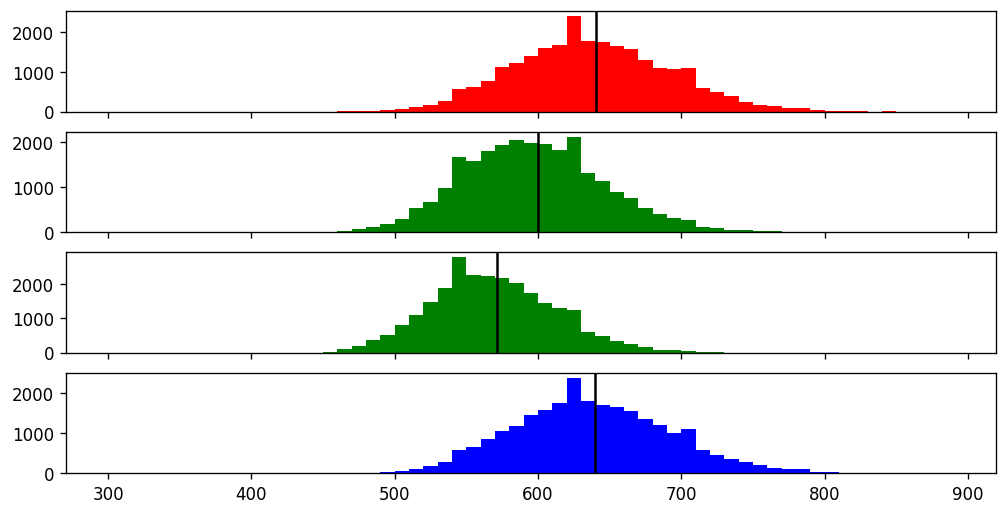

In [744]:
fig,ax = plt.subplots(4,figsize=(10,5),sharex=True)
for i,color in enumerate(BayerImage.channels):
    plt.sca(ax[i])
    plt.hist(img[color].ravel()[::20],bins=np.arange(300,900,10),log=False,color=color[0].lower());
    plt.axvline(img[color].mean(),c='k')

In [745]:
img.apply(lambda x: x-x.mean(), inplace=True)

<BayerImage of size (960, 540) with float32 pixels>

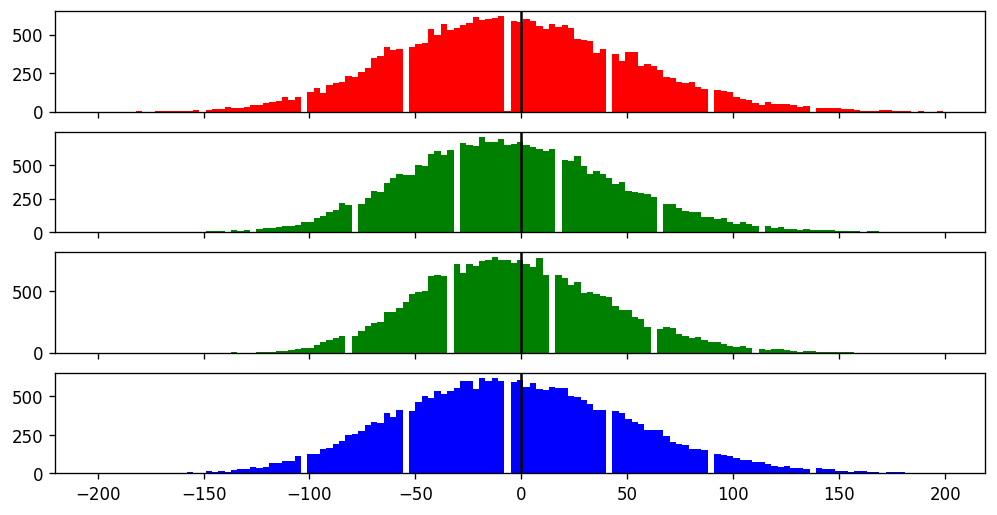

In [746]:
fig,ax = plt.subplots(4,figsize=(10,5),sharex=True)
for i,color in enumerate(BayerImage.channels):
    plt.sca(ax[i])
    plt.hist(img[color].ravel()[::20],bins=np.arange(-200,200,3),log=False,color=color[0].lower());
    plt.axvline(img[color].mean(),c='k')

# Total Poisson error

In [747]:
img_error = img.apply(lambda X: calc_total_error(X,np.ones_like(X)*SigmaClip(3)(X).std(),2.5)) # this value for gain is a total and miserable lie

# Source finding

In [748]:
total_img = (img.G1 + img.G2 + img.R + img.B)

In [749]:
peaks = find_peaks(total_img, threshold=600.0,border_width=10,centroid_func=centroid_quadratic)#.to_pandas()

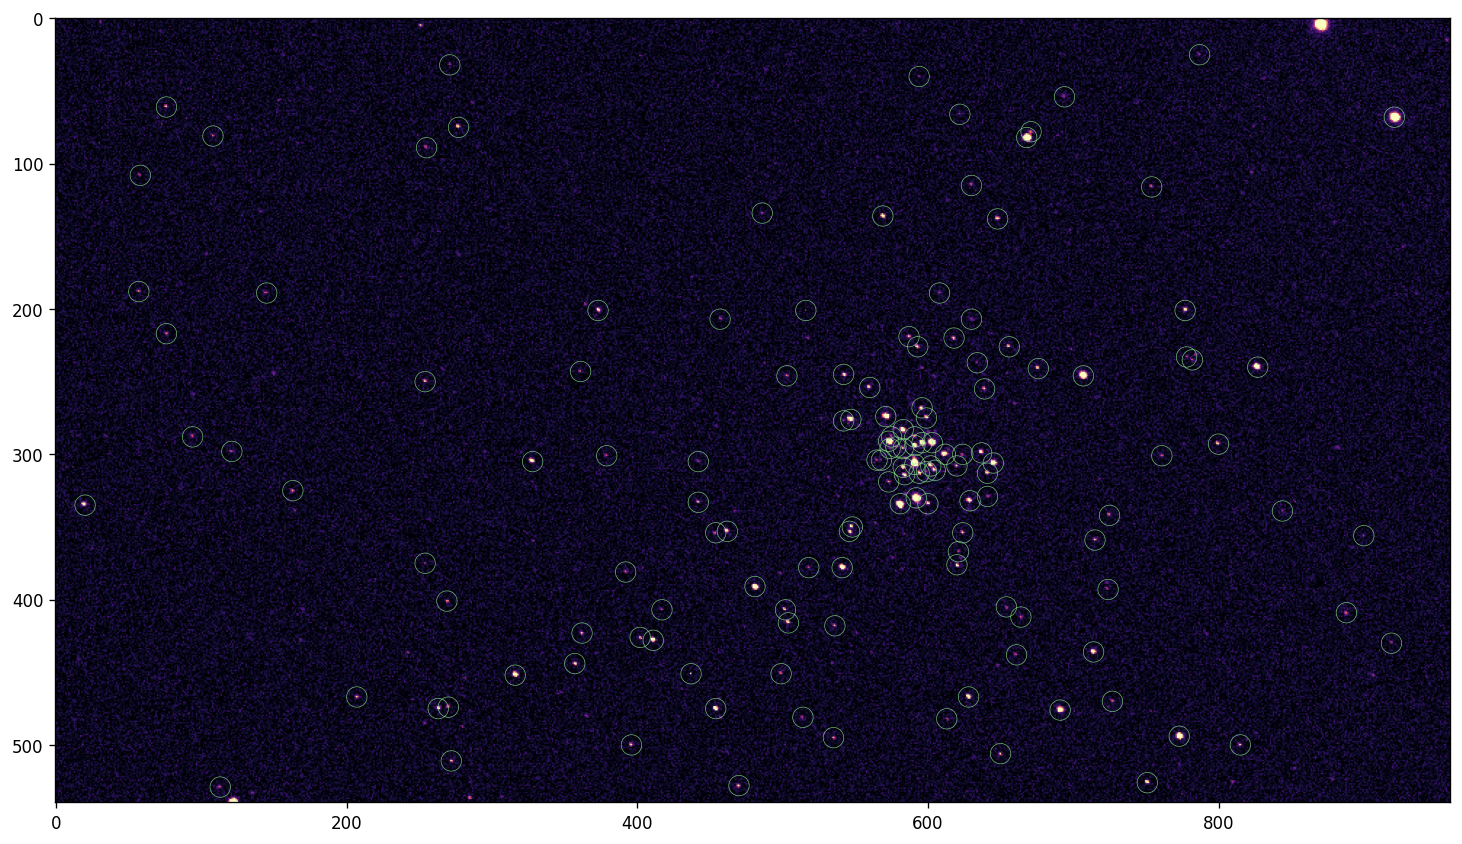

In [750]:
plt.figure(figsize=(15,10))#,dpi=250)
plt.imshow(total_img.T,vmin=-100,vmax=1500)
plt.scatter(peaks["y_peak"],peaks["x_peak"],fc="none",s=150,ec="lightgreen",lw=0.4,alpha=0.8)

We segregate the joined sources with DBSCAN

In [751]:
db = DBSCAN(eps=10.0,min_samples=2,metric="euclidean").fit(peaks[["x_peak","y_peak"]].to_pandas())

In [752]:
peaks["labels"] = db.labels_
peaks["x"] = peaks["x_peak"]
peaks["y"] = peaks["y_peak"]
peaks.sort("peak_value",reverse=True)

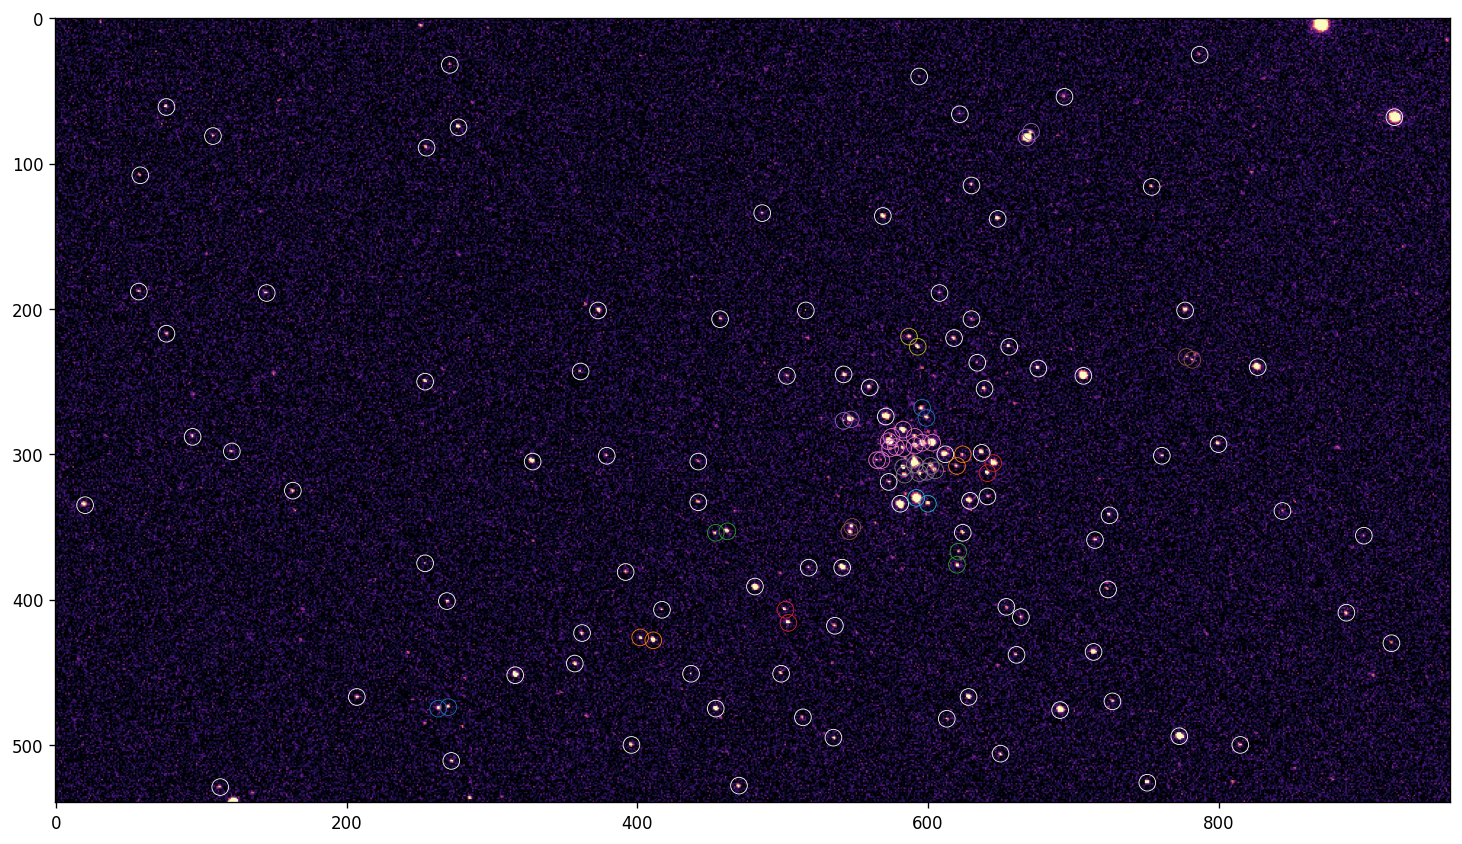

In [753]:
plt.figure(figsize=(15,10))#,dpi=250)
plt.imshow(total_img.T,vmin=-50,vmax=800)
df = peaks.to_pandas()
for label,group in df.groupby("labels"):
    color = f"C{label%(df["labels"].max()+1):02}" if label!=-1 else "w"
    plt.scatter(group["y_peak"],group["x_peak"],fc="none",ec=color,s=100,lw=0.5,alpha=1)

In [754]:
clean_peaks = peaks[(peaks["labels"] == -1) & (peaks["peak_value"]>2_000)]
nddata = NDData(data=img.B)
stars = extract_stars(nddata, clean_peaks, size=15)

In [755]:
len(stars)

30

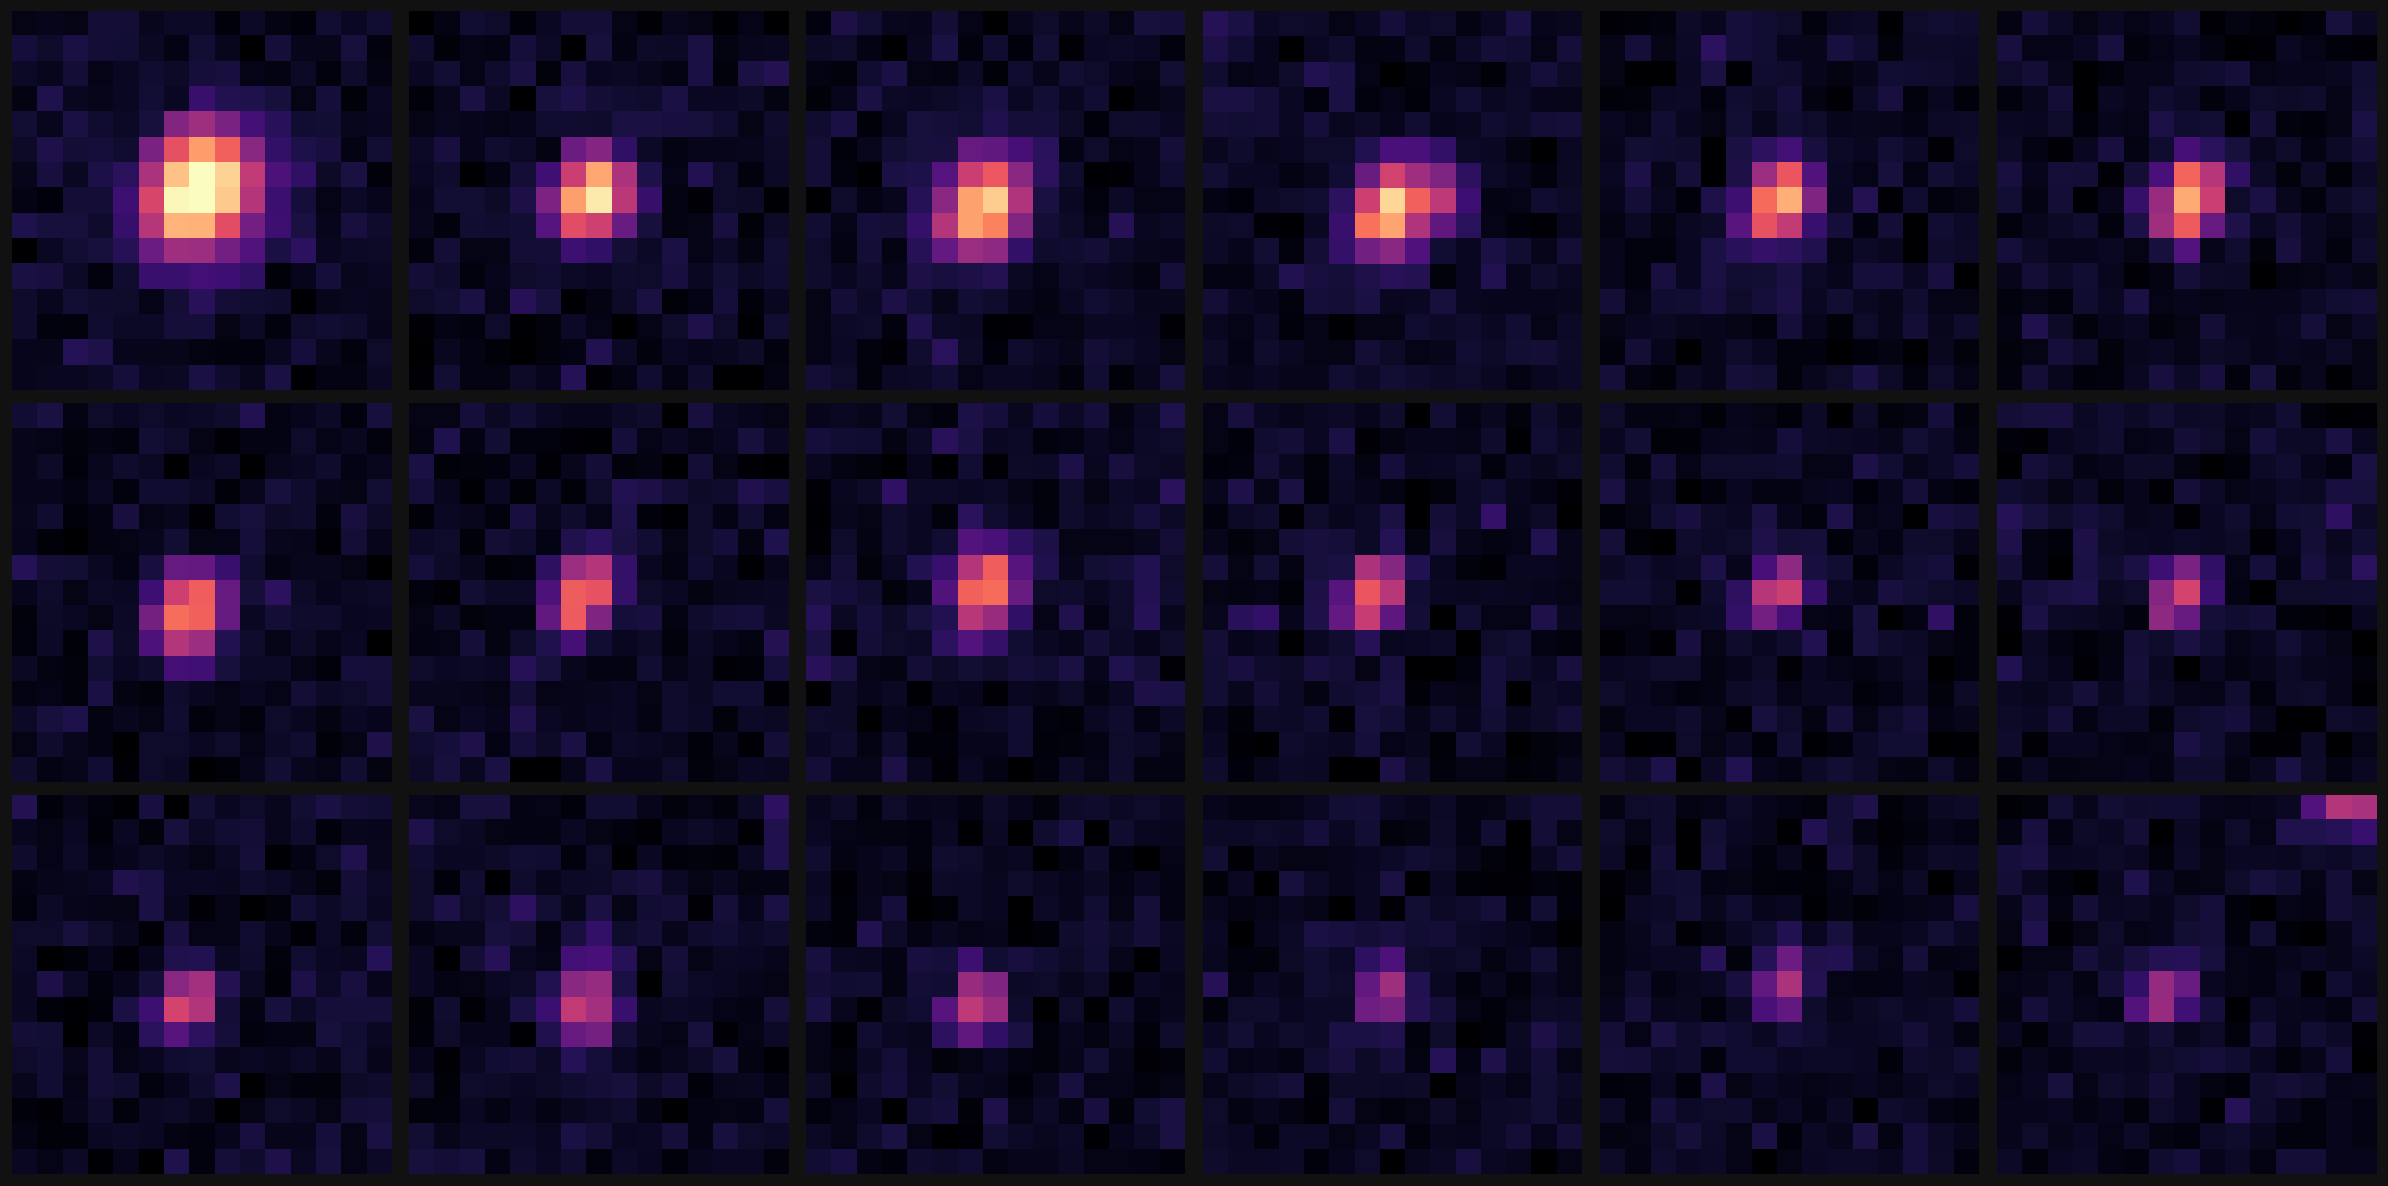

In [756]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 3
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10), squeeze=True)
fig.set_facecolor("#111111")
ax = ax.ravel()
for i in range(nrows * ncols):
    try:
        norm = simple_norm(stars[i],"asinh",vmin=-100,vmax=30_000,asinh_a=0.01)
        ax[i].imshow(stars[i], norm=norm, origin='lower')
    except IndexError:
        pass
    finally:
        ax[i].set_axis_off()

plt.tight_layout()

# Analytic PSF

In [779]:
model = CircularGaussianPRF(x_0=7,y_0=7, fwhm=1.5)
model.fwhm.fixed = False

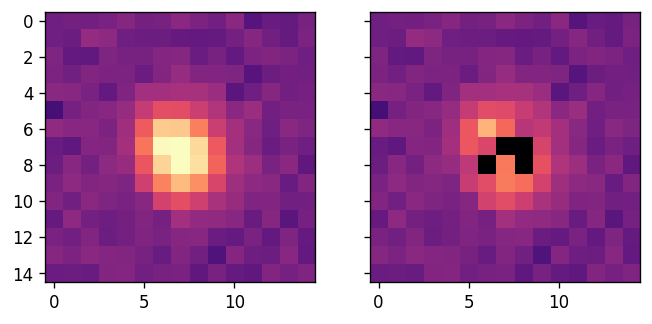

 id x_fit  y_fit  fwhm_fit   flux_fit 
--- ------ ------ -------- -----------
  1 6.9490 7.4321   1.5081 246409.0906


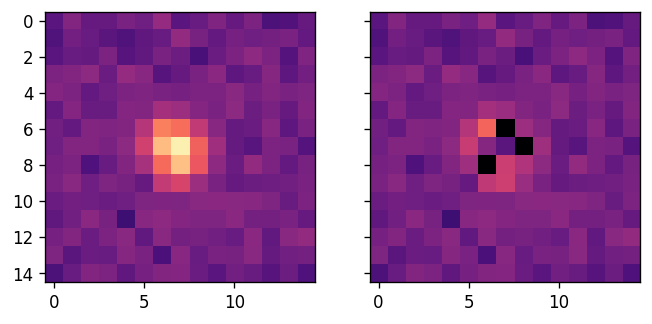

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.8039 7.1990   1.1955 58941.2355


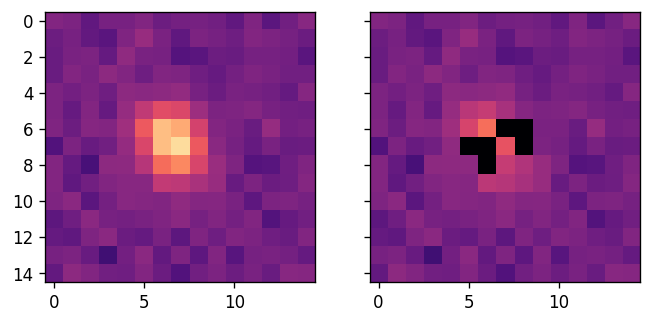

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.6087 6.7528   1.5455 63009.9238


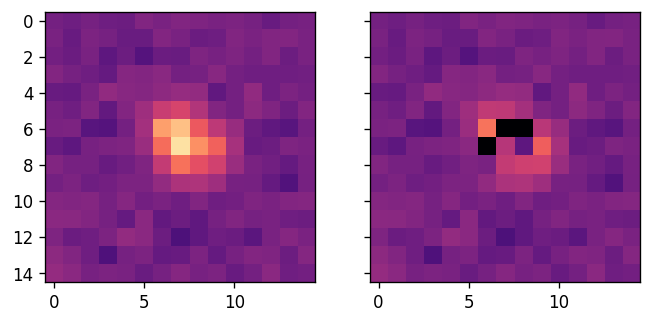

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.9942 6.6974   1.2888 51095.6220


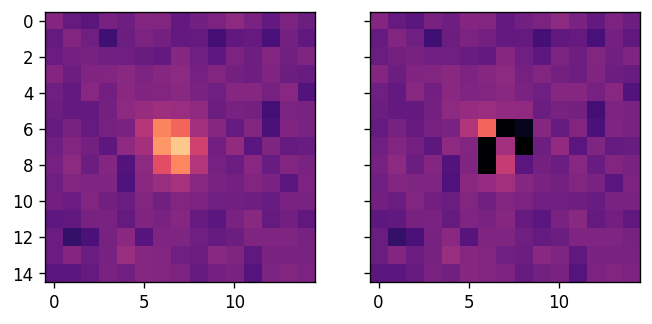

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.7516 7.0220   1.2918 32356.3941


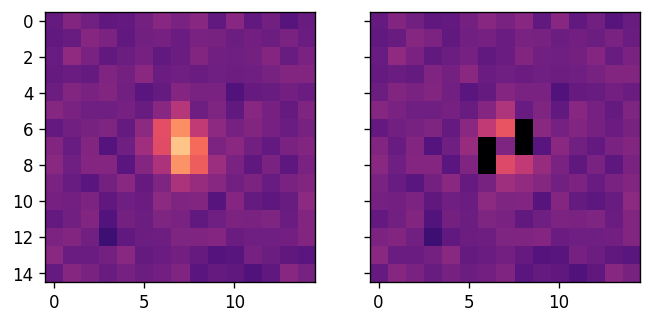

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 7.0601 7.0539   1.3524 30640.6420


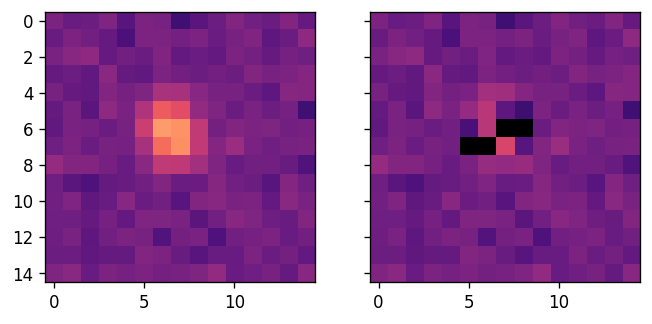

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.5267 6.2736   1.6507 26899.6650


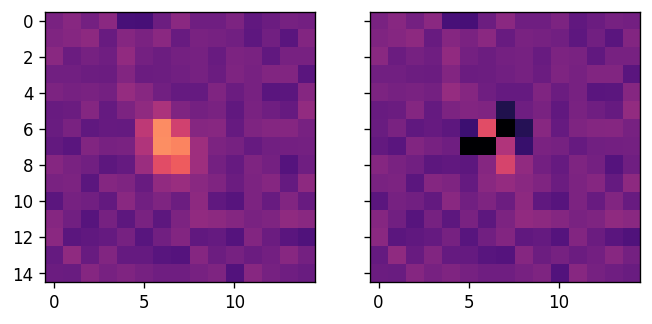

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.3074 6.7507   1.5609 20660.9169


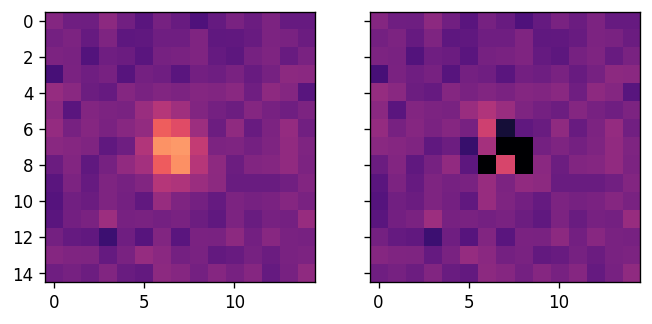

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.6287 7.2461   1.5669 24853.0768


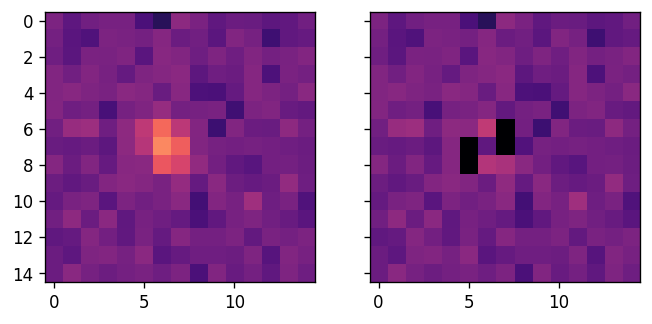

 id x_fit  y_fit  fwhm_fit  flux_fit 
--- ------ ------ -------- ----------
  1 6.1757 6.9074   1.5004 14306.0730


In [780]:
for i in range(10):
    data = stars[i]._data[0]._data
    model.flux.value = data.sum()
    psfphot = PSFPhotometry(model,(5,5))
    init_params = QTable()
    init_params["x"] = [x0]
    init_params["y"] = [y0]
    init_params["flux"] = data.sum()
    _ = psfphot(data,init_params=init_params)
    
    fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
    ax[0].imshow(data,norm=norm)
    ax[1].imshow(psfphot.make_residual_image(data),norm=norm)
    plt.show()
    plt.close()

    cols = ['x_fit', 'y_fit', 'fwhm_fit', 'flux_fit']
    for col in cols:
        psfphot.results[col].info.format = '.4f'
    print(psfphot.results[['id'] + cols])

In [759]:
psfphot.results

<QTable length=1>
  id  group_id group_size local_bkg ...         cfit         reduced_chi2 flags
int64  int64     int64     float64  ...       float64          float64    int64
----- -------- ---------- --------- ... -------------------- ------------ -----
    1        1          1       0.0 ... -0.01521943493478683          nan     0

In [760]:
labels = np.array(peaks["labels"])
i = labels.max() + 1
for j,x in enumerate(labels):
    if x <= 0:
        labels[j] = i
        i += 1
init_params = QTable()
init_params["x"] = np.array(peaks["x_centroid"])
init_params["y"] = np.array(peaks["y_centroid"])
init_params["flux_init"] = peaks["peak_value"]
init_params["group_id"] = labels

model = CircularGaussianPRF(x_0=7,y_0=7, fwhm=1.5,flux=100.)
model.flux.bounds = [0,None]
psfphot = PSFPhotometry(model,(7,7),fitter_maxiters=1000)


results = {}
for ch in BayerImage.channels:
    results[ch] = psfphot(img[ch],init_params=init_params,error=img_error[ch])
    results[ch]["mag"] = -5/2 * np.log10(results[ch]["flux_fit"])
    results[ch]["mag_err"] = 5 * results[ch]["flux_err"] / results[ch]["flux_fit"] / np.log(100)

In [761]:
mask = np.sum([(abs(v["mag_err"] / v["mag"]) > 0.2) | (v["mag_err"]<=0) for v in results.values()],axis=0) == 0 # we keep those with relative uncertainty < 20% on all channels
results = {k:v[mask] for k,v in results.items()} 

Text(0, 0.5, 'R magnitude')

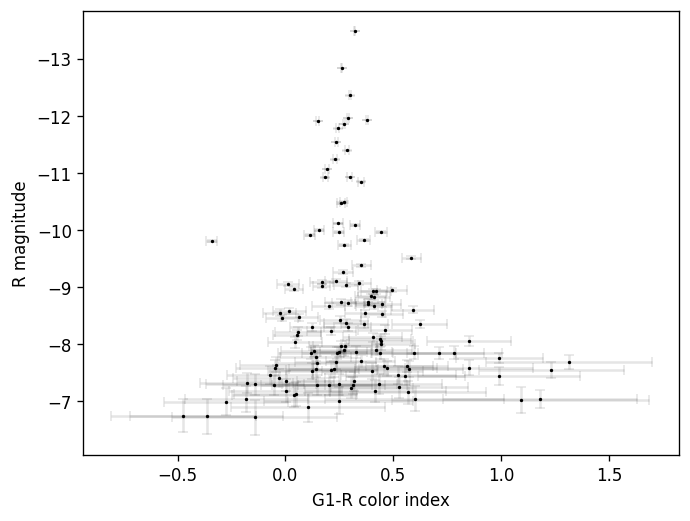

In [762]:
red = "R"
blue = "G1"

color = results[blue]["mag"] - results[red]["mag"]
color_err = np.hypot(results[blue]["mag_err"], results[red]["mag_err"])

ordinate = results[red]["mag"]
ordinate_err = results[red]["mag_err"]

plt.scatter(color,ordinate,c='k',s=1)
plt.errorbar(color,ordinate,ordinate_err,color_err,fmt=" k",capsize=3,alpha=0.1)
plt.gca().invert_yaxis()
#plt.xlim(-2,3)
#plt.ylim(-4,-15)
plt.xlabel(f"{blue}-{red} color index")
plt.ylabel(f"{red} magnitude")

Text(0, 0.5, 'G1 magnitude')

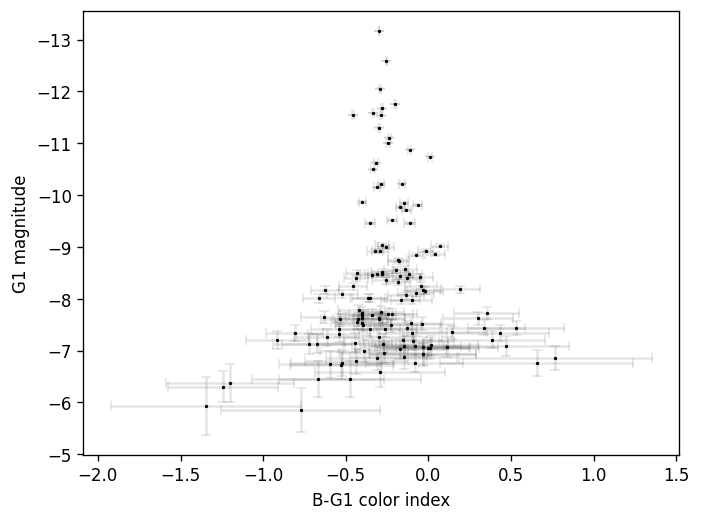

In [763]:
red = "G1"
blue = "B"

color = results[blue]["mag"] - results[red]["mag"]
color_err = np.hypot(results[blue]["mag_err"], results[red]["mag_err"])

ordinate = results[red]["mag"]
ordinate_err = results[red]["mag_err"]

plt.scatter(color,ordinate,c='k',s=1)
plt.errorbar(color,ordinate,ordinate_err,color_err,fmt=" k",capsize=3,alpha=0.1)
plt.gca().invert_yaxis()
#plt.xlim(-2,3)
#plt.ylim(-4,-15)
plt.xlabel(f"{blue}-{red} color index")
plt.ylabel(f"{red} magnitude")

Text(0, 0.5, 'R magnitude')

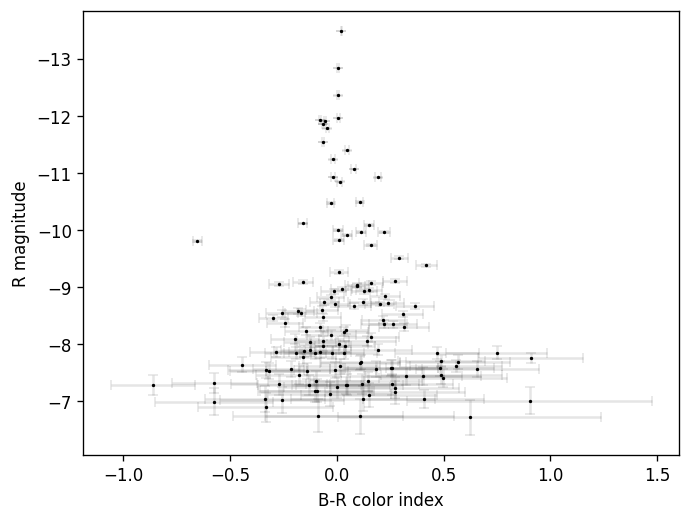

In [764]:
red = "R"
blue = "B"

color = results[blue]["mag"] - results[red]["mag"]
color_err = np.hypot(results[blue]["mag_err"], results[red]["mag_err"])

ordinate = results[red]["mag"]
ordinate_err = results[red]["mag_err"]

plt.scatter(color,ordinate,c='k',s=1)
plt.errorbar(color,ordinate,ordinate_err,color_err,fmt=" k",capsize=3,alpha=0.1)
plt.gca().invert_yaxis()
#plt.xlim(-2,3)
#plt.ylim(-4,-15)
plt.xlabel(f"{blue}-{red} color index")
plt.ylabel(f"{red} magnitude")

Text(0, 0.5, 'B-G1 color index')

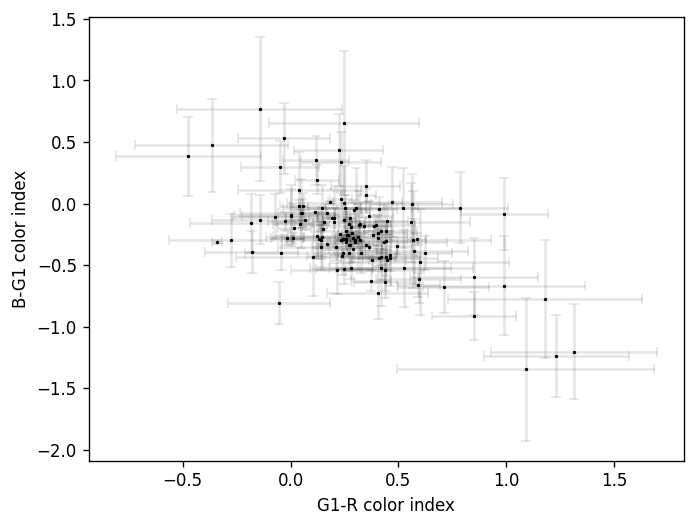

In [765]:
red = "R"
blue = "G1"

color_A = results[blue]["mag"] - results[red]["mag"]
color_A_err = np.hypot(results[blue]["mag_err"], results[red]["mag_err"])
color_A_label = f"{blue}-{red} color index"

red = "G1"
blue = "B"

color_B = results[blue]["mag"] - results[red]["mag"]
color_B_err = np.hypot(results[blue]["mag_err"], results[red]["mag_err"])
color_B_label = f"{blue}-{red} color index"

plt.scatter(color_A,color_B,c='k',s=1)
plt.errorbar(color_A,color_B,color_B_err,color_A_err,fmt=" k",capsize=3,alpha=0.1)
#plt.xlim(-3,3)
#plt.ylim(-3,3)
plt.xlabel(color_A_label)
plt.ylabel(color_B_label)

# Effective PSF?

In [781]:
epsf,fitted_stars = EPSFBuilder(oversampling=5,maxiters=10,smoothing_kernel="quadratic",center_accuracy=1e-5,recentering_maxiters=100)(stars)

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

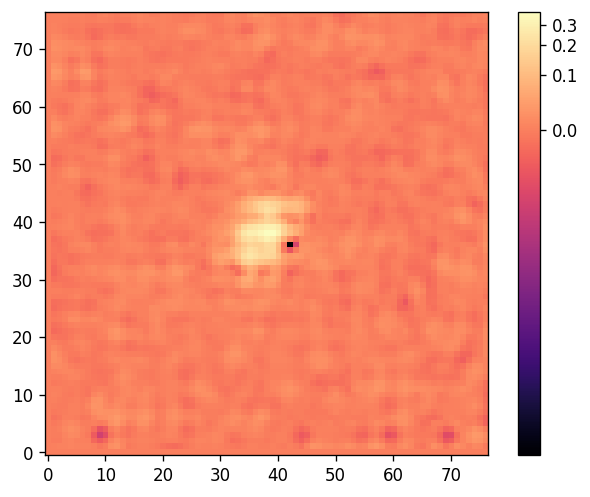

In [782]:
norm = simple_norm(epsf.data,"log")
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='magma')
plt.colorbar()

# Fitting one star

In [795]:
init_params = QTable()
init_params["x"] = [clean_peaks["x_centroid"][1]]
init_params["y"] = [clean_peaks["y_centroid"][1]]

In [796]:
psfphot = PSFPhotometry(
    psf_model=epsf, 
    fit_shape=(17,17),
    aperture_radius=16
)

In [797]:
phot = psfphot(img.B, error=img_error.B, init_params=init_params)

In [798]:
resid = psfphot.make_residual_image(img.B)
norm = simple_norm(stars[1],"asinh",vmin=-200,vmax=30_000,asinh_a=0.001)

In [799]:
init_params

<QTable length=1>
        x                  y        
     float64            float64     
------------------ -----------------
494.01666923785393 773.2864281026162

(700.0, 800.0)

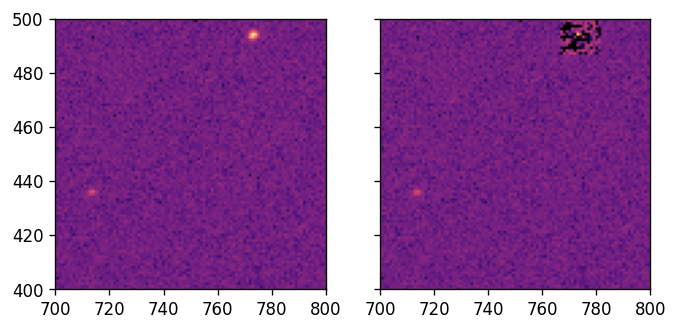

In [802]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)

ax[0].imshow(img.B.T,norm=norm)
ax[1].imshow(resid.T,norm=norm)
plt.ylim(400,500)
plt.xlim(700,800)

In [803]:
phot

<QTable length=1>
  id  group_id group_size ...         cfit           reduced_chi2   flags
int64  int64     int64    ...       float64            float64      int64
----- -------- ---------- ... ------------------- ----------------- -----
    1        1          1 ... 0.17275544470294096 78.04113408684148     0

This is mediocre.

In [804]:
init_params = QTable()
init_params["x"] = np.array(peaks["x_centroid"])
init_params["y"] = np.array(peaks["y_centroid"])
init_params["flux_init"] = peaks["peak_value"]
init_params["group_id"] = labels

epsf.flux.bounds = [0,None]
psfphot = PSFPhotometry(epsf,(7,7),fitter_maxiters=1000)


results = {}
for ch in BayerImage.channels:
    results[ch] = psfphot(img[ch],init_params=init_params,error=img_error[ch])
    results[ch]["mag"] = -5/2 * np.log10(results[ch]["flux_fit"])
    results[ch]["mag_err"] = 5 * results[ch]["flux_err"] / results[ch]["flux_fit"] / np.log(100)

/tmp/ipykernel_4729/2889035590.py:14: RuntimeWarning: invalid value encountered in log10
  results[ch]["mag"] = -5/2 * np.log10(results[ch]["flux_fit"])
/tmp/ipykernel_4729/2889035590.py:14: RuntimeWarning: invalid value encountered in log10
  results[ch]["mag"] = -5/2 * np.log10(results[ch]["flux_fit"])
/tmp/ipykernel_4729/2889035590.py:14: RuntimeWarning: invalid value encountered in log10
  results[ch]["mag"] = -5/2 * np.log10(results[ch]["flux_fit"])


In [805]:
mask = np.sum([(abs(v["mag_err"] / v["mag"]) > 0.2) | (v["mag_err"]<=0) for v in results.values()],axis=0) == 0 # we keep those with relative uncertainty < 20% on all channels

In [806]:
results = {k:v[mask] for k,v in results.items()} 

Text(0, 0.5, 'R magnitude')

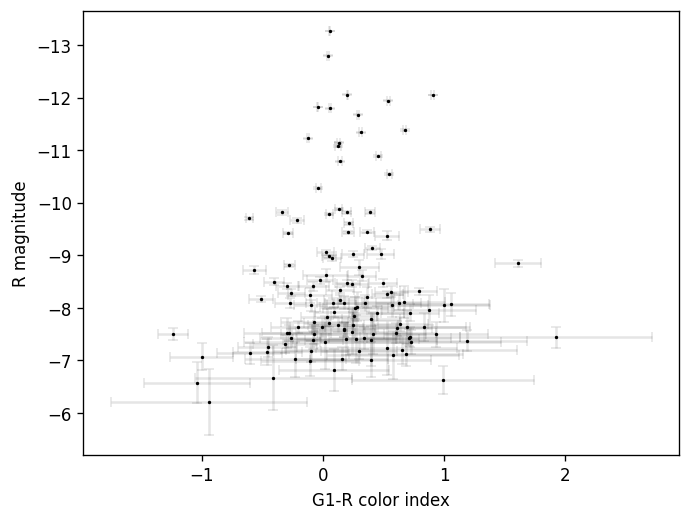

In [807]:
red = "R"
blue = "G1"

color = results[blue]["mag"] - results[red]["mag"]
color_err = np.hypot(results[blue]["mag_err"], results[red]["mag_err"])

ordinate = results[red]["mag"]
ordinate_err = results[red]["mag_err"]

plt.scatter(color,ordinate,c='k',s=1)
plt.errorbar(color,ordinate,ordinate_err,color_err,fmt=" k",capsize=3,alpha=0.1)
plt.gca().invert_yaxis()
#plt.xlim(-2,3)
#plt.ylim(-4,-15)
plt.xlabel(f"{blue}-{red} color index")
plt.ylabel(f"{red} magnitude")